# Web scrape Vancouver/UBC Apartments

In [35]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np
from bs4 import BeautifulSoup
from requests import get

#get the first page of housing prices
response = get('https://vancouver.craigslist.org/search/apa?query=-shared+-wanted&hasPic=1&search_distance=4.2&postal=v6r3e9&availabilityMode=0&sale_date=all+dates')
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://vancouver.craigslist.org/search/apa?"
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "query=-shared+-wanted&hasPic=1&search_distance=4.2&postal=v6r3e9&availabilityMode=0&sale_date=all+dates&max_price=4000")

    sleep(randint(5,20))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = page_html.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if True:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "").replace(',', '')) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!


Scrape complete!


In [36]:
import pandas as pd

eb_apts = pd.DataFrame({'posted': post_timing,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(eb_apts.info())
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   posted           360 non-null    object 
 1   post title       360 non-null    object 
 2   number bedrooms  341 non-null    object 
 3   sqft             279 non-null    float64
 4   URL              360 non-null    object 
 5   price            360 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 17.0+ KB
None


,posted,post title,number bedrooms,sqft,URL,price
0,2021-02-25 13:24,Perfect for Students/New Garden Suite/New Dish...,4,1094.0,https://vancouver.craigslist.org/van/apa/d/van...,3499
1,2021-02-25 09:52,2 BEDROOM PLUS DEN (CAN BE 3RD BEDROOM) SUITE,2,1200.0,https://vancouver.craigslist.org/van/apa/d/van...,2300
2,2021-02-20 01:16,one bedroom -UBC,1,620.0,https://vancouver.craigslist.org/van/apa/d/van...,1600
3,2021-03-09 13:19,"Entire Lane-Way House, UBC, Jericho Beach",1,630.0,https://vancouver.craigslist.org/van/apa/d/van...,2350
4,2021-03-09 10:55,1 BEDROOM NEWLY RENOVATED UNIT AVAILABLE IN KITS!,1,NaN,https://vancouver.craigslist.org/van/apa/d/van...,1775
5,2021-03-08 14:43,3 BEDROOM GARDEN SUITE IN KITS,3,1000.0,https://vancouver.craigslist.org/van/apa/d/van...,2800
6,2021-03-09 13:18,"2 Bdr Basement Suite By UBC, Jericho Beach",2,485.0,https://vancouver.craigslist.org/van/apa/d/van...,2200
7,2021-03-08 15:55,one bedroom -UBC_ beautiful balcony Westgate b...,1,620.0,https://vancouver.craigslist.org/van/apa/d/van...,1600
8,2021-03-14 01:21,"Private room in shared accomodation,UBC,Kitsil...",1,NaN,https://vancouver.craigslist.org/van/apa/d/van...,895
9,2021-03-04 21:04,one bedroom -UBC_ beautiful balcony Westgate b...,1,620.0,https://vancouver.craigslist.org/van/apa/d/van...,1600


# Data cleaning

In [37]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
eb_apts = eb_apts.drop_duplicates(subset='URL')
len(eb_apts.drop_duplicates(subset='URL'))

eb_apts = eb_apts.drop(eb_apts[eb_apts['price'] < 500].index)

#make the number bedrooms to a float (since np.nan is a float too)
eb_apts['number bedrooms'] = eb_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['posted'] = pd.to_datetime(eb_apts['posted'])

# Exploratory Data Analysis

In [38]:
eb_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 359
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   posted           346 non-null    datetime64[ns]
 1   post title       346 non-null    object        
 2   number bedrooms  327 non-null    float64       
 3   sqft             279 non-null    float64       
 4   URL              346 non-null    object        
 5   price            346 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 18.9+ KB


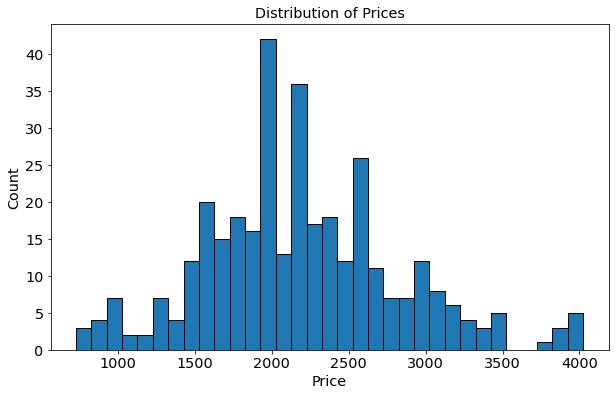

In [39]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
binwidth = 100
y = eb_apts['price']
plt.hist(y, edgecolor='black', bins=range(min(y), max(y) + binwidth, binwidth));
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

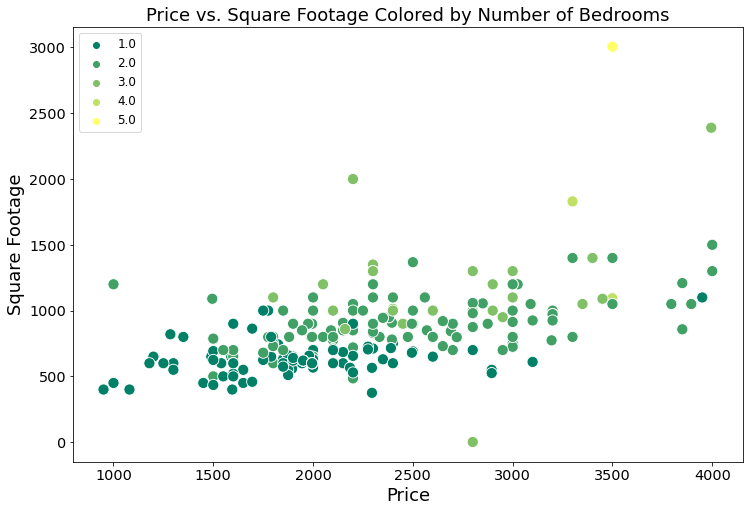

In [40]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=eb_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

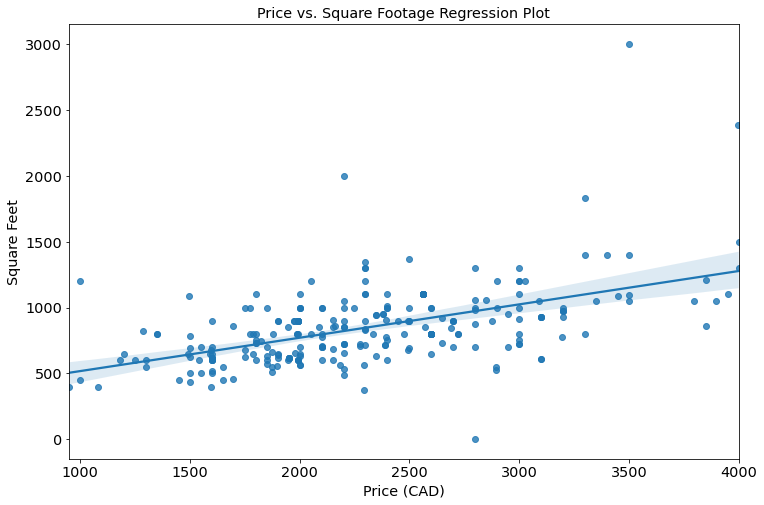

In [41]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=eb_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (CAD)");
plt.ylabel("Square Feet");

In [34]:
eb_apts.corr()

,number bedrooms,sqft,price
number bedrooms,1.000000,0.697364,0.452561
sqft,0.697364,1.000000,0.551841
price,0.452561,0.551841,1.000000


In [ ]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='price', data=eb_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price CAD");
plt.title("Prices by Neighborhood - Boxplots");